# Importing Libraries

In [3]:
import numpy as numpy
import pandas as pd

In [4]:
#Access Google drive for dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
import sklearn
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [8]:
import re
import random
import gensim

In [9]:
from collections import Counter
import unicodedata as udata
import string

In [10]:
print(sklearn.__version__)
print(matplotlib.__version__)
print(numpy.__version__)
print(pd.__version__)
print(nltk.__version__)

1.0.2
3.2.2
1.21.6
1.3.5
3.7


# Reading csv file

In [11]:
df = pd.read_csv("/content/gdrive/MyDrive/Main-Project-1/TwitterSentimentAnalysis(ML Mind)/TwitterSentimentAnalysis.csv", encoding='latin-1', header=None)

In [12]:
df = df.sample(frac=1).reset_index(drop=True)

# Give column names

In [13]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"] 

In [14]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df.head(5)

,sentiment,id,date,query,user,text
0,0,1989236751,Mon Jun 01 00:49:17 PDT 2009,NO_QUERY,Spencer_Sand,@totobird435 I'm missing every key.
1,0,1755601766,Sun May 10 09:33:25 PDT 2009,NO_QUERY,ernho,@karolein_ hope you're not that sad
2,0,1881673412,Fri May 22 05:16:54 PDT 2009,NO_QUERY,Lynseymansfield,Going back for an evil afternoon! grr..
3,0,1882789842,Fri May 22 07:29:25 PDT 2009,NO_QUERY,vacant_heart,Damn! The facebook poker aint loading!
4,4,2061558435,Sat Jun 06 21:07:12 PDT 2009,NO_QUERY,gwenii,Leaving gorgeous Corona.. look @ the full moon...


In [17]:
df = df.drop(["id", "date", "query", "user"], axis = 1) 

In [18]:
df.head(5)

,sentiment,text
0,0,@totobird435 I'm missing every key.
1,0,@karolein_ hope you're not that sad
2,0,Going back for an evil afternoon! grr..
3,0,Damn! The facebook poker aint loading!
4,4,Leaving gorgeous Corona.. look @ the full moon...


In [19]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64












# Cleaning data

In [20]:
df['pre_clean_len'] = [len(t) for t in df.text]

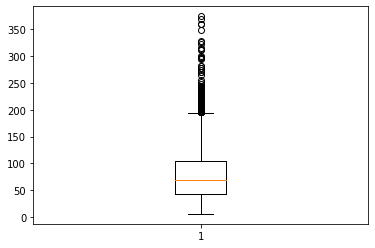

In [21]:
plt.boxplot(df.pre_clean_len)
plt.show()

In [22]:
df[df.pre_clean_len > 140].head(10) 

,sentiment,text,pre_clean_len
41,4,Waiting for &quot;No Agenda&quot; Stream not w...,142
237,4,@ihatecrayons Any chance you gonna do a remake...,142
373,4,@kashiichan Nope. I'm in a 3-way chat with a c...,146
463,4,"Morning everyone. Busy Friday-contracts, revie...",141
588,0,@ThrivingIvory i guess u dont kno what &quot;l...,148
746,4,@rebeccashearing itouch wuhuuuu \o/ hahaha... ...,142
929,4,"What I Meant to Say: At Yardhouse, Waikiki. @l...",141
981,0,"Good Morning Everyone! Breezy today, weather p...",141
1067,4,"Great mood, i have so much to be happy about a...",146
1087,0,don't you just hate it when you waste your who...,142


At this stage, if you want you could remove these outlier tweets

# Cleaning operations

In [23]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'        # remove @ mentions from tweets
pat2 = r'https?://[^ ]+'        # remove URLs from tweets
combined_pat = r'|'.join((pat1, pat2)) #addition of pat1 and pat2
www_pat = r'www.[^ ]+'         # remove URLs from tweets
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   # converting words like isn't to is not
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):  # define tweet_cleaner function to clean the tweets
    soup = BeautifulSoup(text, 'lxml')    # create beautiful soup object
    souped = soup.get_text()   # get only text from the tweets 
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")    # remove utf-8-sig code
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed) # calling combined_pat
    stripped = re.sub(www_pat, '', stripped) #remove URLs
    lower_case = stripped.lower()      # converting all into lower case
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case) # converting words like isn't to is not
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)       # will replace # by space
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1] # Word Punct Tokenize and only consider words whose length is greater than 1
    return (" ".join(words)).strip() # join the words

In [24]:
#Note that we have 1600000 instances. But processing so many instances will take a very very long time.
#Hence, restricting to rather 50000 instances.
limit= 1600000
import time; 
ms = time.time()
#nums = [0,400000,800000,1200000,1600000] # used for batch processing tweets
#nums = [0, 9999]
clean_tweet_texts = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    if i % 10000==0:
        print(i, time.time()-ms)
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  # call tweet_cleaner function and pass parameter as all the tweets to clean the tweets and append cleaned tweets into clean_tweet_texts list

0 6.079673767089844e-05
10000 2.234222888946533
20000 4.595175743103027
30000 6.803098201751709
40000 9.021828889846802
50000 11.183855772018433
60000 13.350577592849731
70000 15.529418468475342
80000 17.710095643997192
90000 19.877796173095703
100000 22.079482555389404
110000 24.275472402572632
120000 26.46429753303528
130000 28.648426294326782
140000 30.948625564575195
150000 33.445072174072266
160000 36.29544448852539
170000 38.4672429561615
180000 40.66106367111206
190000 42.86578106880188
200000 45.058807611465454
210000 47.222291231155396
220000 49.36237907409668
230000 51.509541511535645
240000 53.68237352371216
250000 55.833805322647095
260000 57.9957857131958
270000 60.731714487075806
280000 62.905444860458374
290000 65.06027722358704
300000 67.22980618476868
310000 69.39643669128418
320000 71.52256083488464
330000 73.66344428062439
340000 75.81974077224731
350000 77.98731303215027
360000 80.13220715522766
370000 82.31514382362366
380000 84.44923496246338
390000 86.62736988067

# clean_tweet_texts

In [25]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
word_tokens = [] # initialize list for tokens
for word in clean_tweet_texts:  # for each word in clean_tweet_texts
    word_tokens.append(word_tokenize(word)) #tokenize word in clean_tweet_texts and append it to word_tokens list

# Lemmatizing

In [29]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [30]:
df1 = [] # initialize list df1 to store words after lemmatization
from nltk.stem import WordNetLemmatizer # import WordNetLemmatizer from nltk.stem
lemmatizer = WordNetLemmatizer() # create an object of WordNetLemmatizer
for l in word_tokens: # for loop for every tokens in word_token
    b = [lemmatizer.lemmatize(q) for q in l] #for every tokens in word_token lemmatize word and giev it to b
    df1.append(b) #append b to list df1

# df

In [31]:
clean_df1 =[] # initialize list clean_df1 to join word tokens after lemmatization
for c in df1:  # for loop for each list in df1
    a = " ".join(c) # join words in list with space in between and give it to a
    clean_df1.append(a) # append a to clean_df1

# clean_df1

In [32]:
clean_df = pd.DataFrame(clean_df1,columns=['text']) # convert clean_tweet_texts into dataframe and name it as clean_df
#clean_df['target'] = df.sentiment[:10000] # from earlier dataframe get the sentiments of each tweet and make a new column in clean_df as target and give it all the sentiment score
#clean_df

In [33]:
clean_df['clean_len'] = [len(t) for t in clean_df.text] # Again make a new coloumn in the dataframe and name it as clean_len which 

In [34]:
clean_df[clean_df.clean_len > 140].head(10) # again check if any tweet is more than 140 characters

,text,clean_len


In [35]:
target2 = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    target2.append(df['sentiment'][i])
clean_df['target']=target2
df.head()

,sentiment,text,pre_clean_len
0,0,@totobird435 I'm missing every key.,36
1,0,@karolein_ hope you're not that sad,37
2,0,Going back for an evil afternoon! grr..,40
3,0,Damn! The facebook poker aint loading!,39
4,4,Leaving gorgeous Corona.. look @ the full moon...,63


In [36]:
X = clean_df.text # get all the text in x variable
y = clean_df.target # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y
from collections import Counter
print(set(y)) # equals to list(set(words))
print(Counter(y).values()) #

(1600000,)
(1600000,)
{0, 4}
dict_values([800000, 800000])


In [37]:
X_list = X.tolist()
y_list = y.tolist()

In [38]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [39]:
counter = counter_word(X)
#Length of unique qord in data set
len(counter)

253041

In [40]:
num_words = len(counter)

# Max number of words in a sequence
max_length = 20

In [41]:
#Train test split
from sklearn.model_selection  import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [42]:
y_train = [x if x==0 else 1 for x in y_train.tolist()]
y_test = [x if x==0 else 1 for x in y_test.tolist()]
X_train = X_train.tolist()
X_test = X_test.tolist()

In [43]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [44]:
word_index = tokenizer.word_index

In [45]:
X_train = tokenizer.texts_to_sequences(X_train)

In [46]:
X_train[0]

[6435, 19, 7, 147, 34, 1034, 5057, 9, 672]

In [47]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(
    X_train, maxlen=max_length, padding="post", truncating="post"
)

In [48]:
X_train[0]

array([6435,   19,    7,  147,   34, 1034, 5057,    9,  672,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [49]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(
    X_test, maxlen=max_length, padding="post", truncating="post"
)

In [50]:
import numpy as np
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [51]:
print("Shape of train {}".format(X_train.shape))
print("Shape of test {}".format(X_test.shape))

Shape of train (1280000, 20)
Shape of test (320000, 20)


In [52]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# BiLSTM Model

In [53]:
#Import libraries 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [90]:
#Create Model
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 32)            8097312   
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              106400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8,203,913
Trainable params: 8,203,913
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

Epoch 1/5
20000/20000 [==============================] - 238s 12ms/step - loss: 0.4235 - accuracy: 0.8042 - val_loss: 0.4000 - val_accuracy: 0.8184
Epoch 2/5
20000/20000 [==============================] - 240s 12ms/step - loss: 0.3727 - accuracy: 0.8331 - val_loss: 0.3933 - val_accuracy: 0.8214
Epoch 3/5
20000/20000 [==============================] - 235s 12ms/step - loss: 0.3382 - accuracy: 0.8519 - val_loss: 0.4023 - val_accuracy: 0.8199
Epoch 4/5
20000/20000 [==============================] - 235s 12ms/step - loss: 0.3035 - accuracy: 0.8698 - val_loss: 0.4168 - val_accuracy: 0.8146
Epoch 5/5
20000/20000 [==============================] - 235s 12ms/step - loss: 0.2734 - accuracy: 0.8834 - val_loss: 0.4408 - val_accuracy: 0.8126


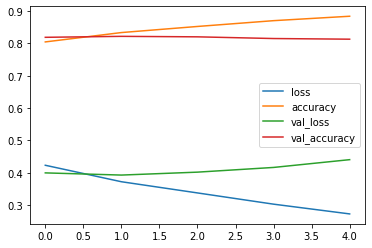

In [93]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [94]:
#predictions = model.predict(X_test)

#predictions1 = model.predict_classes(X_test)
#predictions2 = model.predict_proba(predictions)

In [95]:
y_pred = model.predict(X_test)
demo = np.round(y_pred).astype(int).reshape(-1)
demo

array([0, 0, 1, ..., 1, 1, 1])

In [96]:
demo

array([0, 0, 1, ..., 1, 1, 1])

In [97]:
#Model Evaluation
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,demo))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82    160142
           1       0.83      0.79      0.81    159858

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [98]:
#Confucion matrix
from sklearn.metrics import classification_report,confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, demo)

array([[133642,  26500],
       [ 33461, 126397]])